In [1]:
from trajectory_prediction.datasets import TrajectoryDataset

ds = TrajectoryDataset(root_dir="../../trajectory_optimization/data/rl_trajectories/", N=20)
len(ds)

8000

In [ ]:
import torch
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
from kornia.geometry.camera.perspective import project_points
import numpy as np
from tqdm import trange

# device/mesh : x->forward, y-> right, z->down
# view : x->right, y->down, z->forward
device_frame_from_view_frame = np.array([
  [ 0.,  0.,  1.],
  [ 1.,  0.,  0.],
  [ 0.,  1.,  0.]
])
view_frame_from_device_frame = device_frame_from_view_frame.T

def transform_points(points, offset, rotation):
    """Transform the points from one frame of reference to another.
    
    Args:
        points (Tensor): the points to be transformed, with shape (n, 3).
        offset (tuple): the translation vector.
        rotation (tuple): the rotation angles in degrees.
        
    Returns:
        Tensor: the transformed points, with the same shape as the input points.
    """
    # Create the transformation matrix
    offset = torch.tensor(offset).float()
    rotation = R.from_euler('xyz', rotation, degrees=True).as_matrix()
    transform = torch.from_numpy(rotation).float()

    # Apply the transformation
    transformed_points = torch.mm(points - offset, transform.T)

    return transformed_points

# plot trajectory on the images
cam_offset = (0, -0.170, 0.105) # right, down, forward in meter from center of mass. x is forward
cam_rotation = (12, 0, 0) # pitch, yaw, roll in deg
cam_focal = 0.87 # mm
# F(mm) = F(pixels) * SensorWidth(mm) / ImageWidth (pixel)
# F(pixels) = F(mm) * ImageWidth (pixel) / SensorWidth(mm)
F_x = 0.8726 * 398 / 3.92
F_y = 0.8726 * 398 / 3.92 * (9/16)

for i in trange(80):
    sample = ds[i]
    img = sample["image"] # torch tensor
    traj = sample["trajectory"] # (n, 2) x, y coordinates relative to car center of mass
    # traj = np.array([
    #     [0.5, 0],
    #     [1, 0],
    #     [1.5, 0],
    #     [2, 0],
    #     [2.5, 0],
    #     [3.5, 0],
    # ])

    traj[:, 1] = -traj[:, 1]

    traj_3d = np.pad(traj, (0, 1))
    traj_3d = np.einsum('jk,ik->ij', view_frame_from_device_frame, traj_3d)
    traj_3d = torch.from_numpy(traj_3d).float()

    # Transform the points to the camera's frame
    traj_cam = transform_points(traj_3d, cam_offset, cam_rotation)

    # Compute the camera matrix (assuming square pixels and no skew)
    camera_matrix = torch.tensor([[F_x, 0, img.size(2) / 2], 
                                [0, F_y, img.size(1) / 2], 
                                [0, 0, 1]])

    # Project the points onto the image plane
    proj_points = project_points(traj_cam, camera_matrix)

    # only keep points inside the frame
    valid_x = np.logical_and(proj_points[:, 0] >= 0, proj_points[:, 0] <= 398)
    valid_y = np.logical_and(proj_points[:, 1] >= 0, proj_points[:, 1] <= 224)

    valid_points = np.logical_and(valid_x, valid_y)

    proj_points = proj_points[valid_points]

    # Convert the image tensor to a PIL image
    img_pil = to_pil_image(img)

    # Plot the image and the projected points
    fig = plt.figure()
    plt.imshow(img_pil)
    plt.scatter(proj_points[:, 0].numpy(), proj_points[:, 1].numpy(), color='blue')
    # plt.show()
    plt.savefig(f"proj/{i}.png")

    # plot 2d traj
    # fig = plt.figure()
    # plt.ylim(0, 1.5)  # setting the limit of x axis
    # plt.xlim(-1, 1)  # setting the limit of y axis
    # plt.scatter(traj[:, 1], traj[:, 0], color='blue')
    # plt.savefig(f"2d/{i}.png")

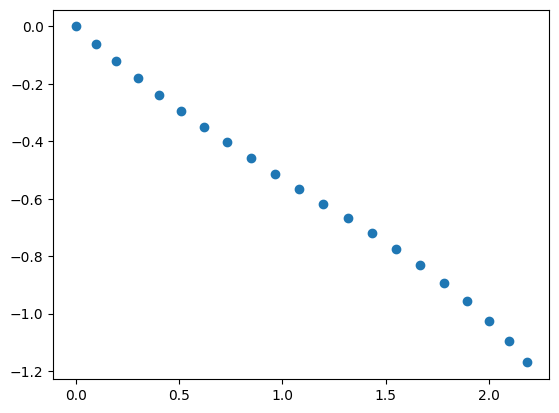

In [4]:
plt.scatter(traj[:, 0], traj[:, 1])

In [1]:
# test ds
from trajectory_prediction.datasets import TestTrajectoryDataset

ds = TestTrajectoryDataset("../data/real_images_test_set/")

In [2]:
ds.paths

[PosixPath('../data/real_images_test_set/0225.png'),
 PosixPath('../data/real_images_test_set/0226.png'),
 PosixPath('../data/real_images_test_set/0227.png'),
 PosixPath('../data/real_images_test_set/0228.png'),
 PosixPath('../data/real_images_test_set/0229.png'),
 PosixPath('../data/real_images_test_set/0230.png'),
 PosixPath('../data/real_images_test_set/0231.png'),
 PosixPath('../data/real_images_test_set/0232.png'),
 PosixPath('../data/real_images_test_set/0233.png'),
 PosixPath('../data/real_images_test_set/0234.png'),
 PosixPath('../data/real_images_test_set/0235.png'),
 PosixPath('../data/real_images_test_set/0236.png'),
 PosixPath('../data/real_images_test_set/0237.png'),
 PosixPath('../data/real_images_test_set/0238.png'),
 PosixPath('../data/real_images_test_set/0239.png'),
 PosixPath('../data/real_images_test_set/0240.png'),
 PosixPath('../data/real_images_test_set/0241.png'),
 PosixPath('../data/real_images_test_set/0242.png'),
 PosixPath('../data/real_images_test_set/0243.